<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_q1lfulldataset_splitting_modeling_decisiontree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach: 
Split Xq1 and yq1 into 80-20 train validation split.
save them as separate. 

looking at
1. log reg
2. decision tree
3. skipping svm and knn.
4. random forest
5. adaboost
6. xgboost
7. neural net dense in keras

compare best performances for each type of model. 

Getting yq1 and Xq1:

Getting yq1 from datadfq1

In [2]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Getting saved yq1 from drive:

Gatting Xq1 from drive

In [3]:
Xq1 = decompress_pickle(path_name+"Xq1all.pbz2") 
yq1 = decompress_pickle(path_name+"yq1all.pbz2") 

In [4]:
type(Xq1), type(yq1)

(scipy.sparse.coo.coo_matrix, pandas.core.series.Series)

In [5]:
from scipy.sparse import coo_matrix

In [6]:
Xq1.shape, yq1.shape

((7313354, 2233), (7313354,))

splitting into 80-20 training and validation set with a random state = 5. (had to remove stratify argument, because it doesn't work for sparse arrays)

In [7]:
from sklearn.model_selection import train_test_split

Xq1_train, Xq1_valid, yq1_train, yq1_valid = train_test_split(Xq1,yq1,test_size=0.2,random_state=5)

In [8]:
Xq1_train.shape, Xq1_valid.shape, yq1_train.shape, yq1_valid.shape

((5850683, 2233), (1462671, 2233), (5850683,), (1462671,))

Fraction of ones in the train and validation sets

In [9]:
yq1_train.sum()/yq1_train.shape[0], yq1_valid.sum()/yq1_valid.shape[0]

(0.1611603294863181, 0.16108748994134703)

They are about the same, we will use this split to test a number of models. They are saved below:

First, we scale and transform the data using the min-max scaler. 

In [10]:
from sklearn.preprocessing import MaxAbsScaler # used because sparse array not supported by MinMaxScaler
mm_scaler = MaxAbsScaler()

mm_scaler.fit(Xq1_train)
Xq1_mm_train = mm_scaler.transform(Xq1_train)
Xq1_mm_valid = mm_scaler.transform(Xq1_valid)


### Decision tree classifier
 


In [38]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=9)
dtree.fit(Xq1_train,yq1_train)

DecisionTreeClassifier(max_depth=9)

In [45]:
yq1_train_preds_proba = dtree.predict_proba(Xq1_train)[:,1]
yq1_valid_preds_proba = dtree.predict_proba(Xq1_valid)[:,1]

In [40]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay, roc_auc_score


In [41]:
accuracy_score(yq1_valid,np.where(yq1_valid_preds_proba>0.5,1,0))

0.8398395811498279

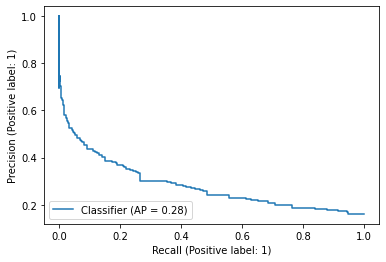

In [46]:
PrecisionRecallDisplay.from_predictions(yq1_valid,yq1_valid_preds_proba)

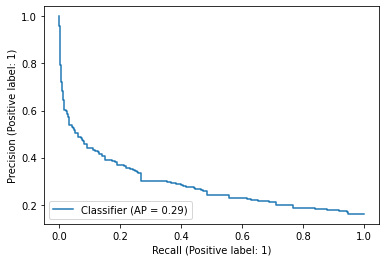

In [47]:
PrecisionRecallDisplay.from_predictions(yq1_train,yq1_train_preds_proba)

In [44]:
roc_auc_score(yq1_valid,yq1_valid_preds_proba)

0.6512656160788077

In [48]:
compressed_pickle(path_name+"Decisiontreemd9_q1_1",dtree)